In [ ]:
# https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train

# Pytorch starter - FasterRCNN Train
In this notebook I enabled the GPU and the Internet access (needed for the pre-trained weights). We can not use Internet during inference, so I'll create another notebook for commiting. Stay tuned!

You can find the inference notebook here

FasterRCNN from torchvision
Use Resnet50 backbone
Albumentation enabled (simple flip for now)

In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = 'global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [4]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(147793, 5)

In [5]:
train_df.sample(5)

,image_id,width,height,bbox,source
96117,d46e680e0,1024,1024,"[457.0, 31.0, 60.0, 95.0]",ethz_1
115958,7767b2fe0,1024,1024,"[960.0, 371.0, 64.0, 48.0]",arvalis_3
143077,fa060c1f8,1024,1024,"[928.0, 968.0, 63.0, 56.0]",rres_1
91230,9458dee84,1024,1024,"[228.0, 494.0, 73.0, 50.0]",ethz_1
45875,4af27998f,1024,1024,"[190, 34, 50, 59]",arvalis_1


### Make bbox info. Takes a few minutes

In [7]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
#     r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
#     if len(r) == 0:
#         r = [-1, -1, -1, -1]
#     else:    
    r = eval(x)
    return r

# bbox -> x, y, w, h
train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)

# Set types
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [8]:
train_df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [16]:
train_df[train_df['x'].isnull()]

,image_id,width,height,source,x,y,w,h


### Make validation set. Split train into val/train

In [9]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

In [10]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [11]:
valid_df.shape, train_df.shape

((25006, 8), (122787, 8))

### Dataset Class

In [12]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]


In [13]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Create the model

In [33]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [34]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [38]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [39]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [40]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [41]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

# Sample

In [23]:
images, targets, image_ids = next(iter(train_data_loader))
print(len(images), len(targets))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

16 16


In [24]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


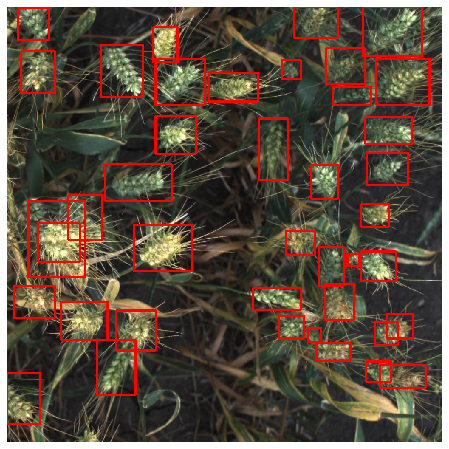

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# Train

In [26]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 2

In [27]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

KeyboardInterrupt: 

In [118]:
images, targets, image_ids = next(iter(valid_data_loader))
for image in images:
    print("Image:", image.shape)
    
for target in targets:
    print('target:', type(target))

Image: torch.Size([3, 1024, 1024])
Image: torch.Size([3, 1024, 1024])
Image: torch.Size([3, 1024, 1024])
Image: torch.Size([3, 1024, 1024])
Image: torch.Size([3, 1024, 1024])
Image: torch.Size([3, 1024, 1024])
Image: torch.Size([3, 1024, 1024])
Image: torch.Size([3, 1024, 1024])
target: <class 'dict'>
target: <class 'dict'>
target: <class 'dict'>
target: <class 'dict'>
target: <class 'dict'>
target: <class 'dict'>
target: <class 'dict'>
target: <class 'dict'>


In [119]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

for image in images:
    print("Image:", image.shape)
    
for target in targets:
    print('target:', type(target))

Image: torch.Size([3, 1024, 1024])
Image: torch.Size([3, 1024, 1024])
Image: torch.Size([3, 1024, 1024])
Image: torch.Size([3, 1024, 1024])
Image: torch.Size([3, 1024, 1024])
Image: torch.Size([3, 1024, 1024])
Image: torch.Size([3, 1024, 1024])
Image: torch.Size([3, 1024, 1024])
target: <class 'dict'>
target: <class 'dict'>
target: <class 'dict'>
target: <class 'dict'>
target: <class 'dict'>
target: <class 'dict'>
target: <class 'dict'>
target: <class 'dict'>


In [120]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()


In [121]:
%%time
display(model.eval())
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

CPU times: user 42.5 s, sys: 17.5 s, total: 60 s
Wall time: 48.6 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


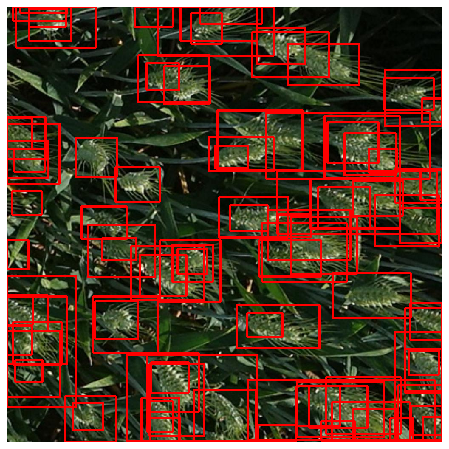

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [127]:
# torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn_tmp.pth')

In [128]:
weights = torch.load('fasterrcnn_resnet50_fpn_tmp.pth')
model.load_state_dict(weights)
display(model.eval())

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [129]:
for images, targets, image_ids in iter(valid_data_loader):
    
    boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[1].permute(1,2,0).cpu().numpy()

    
    outputs = model(images)
    break

In [130]:
original_image.shape

(1024, 1024, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dict_keys(['boxes', 'labels', 'scores'])
Len boxes: 100
After NMS: 100
dict_keys(['boxes', 'labels', 'scores'])
Len boxes: 96
After NMS: 96


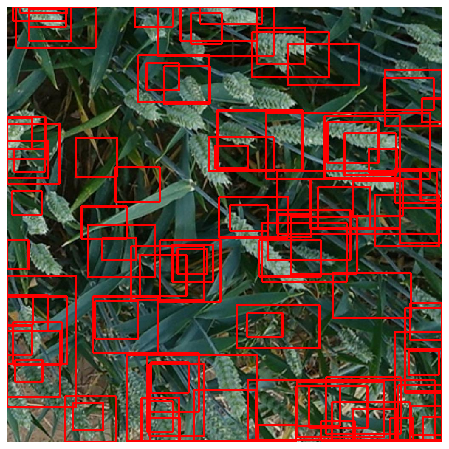

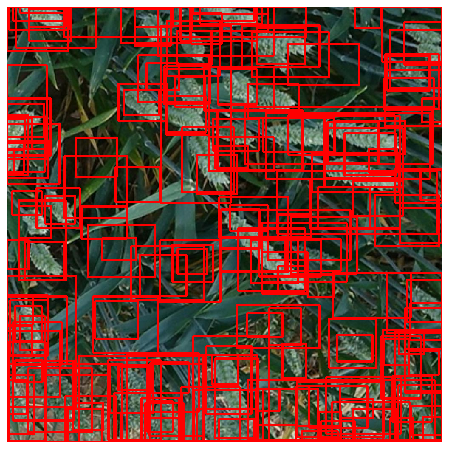

In [105]:

for images, targets, image_ids in iter(valid_data_loader):
    
    boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[1].permute(1,2,0).cpu().numpy()

    
    outputs = model(images)

    for output in outputs:
        original_image = sample.copy()
        prediction_image = sample.copy()


        print(output.keys())
        boxes = output['boxes']
        print("Len boxes: {}".format(len(boxes)))
        labels = output['labels']
        scores = output['scores']

        box_result = output['boxes']
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))

        indices = torchvision.ops.nms(boxes, scores, 0.5)
        print("After NMS:", len(indices))
        for i, (box, score) in enumerate(zip(boxes, scores)):
    #         print(box, score)
            if i in indices:
                cv2.rectangle(prediction_image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)

        ax.set_axis_off()
        ax.imshow(prediction_image)


In [132]:

def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

def is_overlapped(pred_box, gt_boxes, iou_th=0.5):
    result=False
    for gt in gt_boxes:
        iou = calc_iou(pred_box, gt)
        
        if iou > iou_th:
            result = True
            
    return result


for image, output, target in zip(images, outputs, targets):
    
    sample = image.permute(1,2,0).cpu().numpy()
    original_image = sample.copy()
    prediction_image = sample.copy()

    print(output.keys())
    boxes = output['boxes']
    print("Len boxes: {}".format(len(boxes)))
    labels = output['labels']
    scores = output['scores']

    box_result = output['boxes']
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    indices = torchvision.ops.nms(boxes, scores, 0.5)
    
    y_gt = []
    print("After NMS:", len(indices))
    
    iou_th = 0.5
    for i, (box, score) in enumerate(zip(boxes, scores)):
        if i in indices:  # Only boxes survived from the NMS procedure.
            
            if is_overlapped(box, gt_boxes, iou_th=iou_th):
                y_gt.append(1)
            else:
                y_gt.append(0)
    
    ap = average_precision_score(y_true, y_scores)
    print("AP:{}".format(ap))
    
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    gt_boxes = target['boxes']
    for i, (box, score) in enumerate(zip(gt_boxes, scores)):
        if i in indices:
            cv2.rectangle(prediction_image,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0, 0, 220), 3)
    
    
    
    ax.set_axis_off()
    ax.imshow(prediction_image)
    plt.show()


SyntaxError: invalid syntax (<ipython-input-132-b81829af261f>, line 22)

In [133]:
text = "74.5 78.3 69.2 53.2 36.6 77.3 78.2 82.0 40.7 72.7 67.9 79.6 79.2 73.0 69.0 30.1 65.4 70.2 75.8 65.8"

sum([float(ele) for ele in text.split()]) / len(text.split())
    

66.935

In [135]:
text = "84.3 82.0 77.7 68.9 65.7 88.1 88.4 88.9 63.6 86.3 70.8 85.9 87.6 80.1 82.3 53.6 80.4 75.8 86.6 78.9"
sum([float(ele) for ele in text.split()]) / len(text.split())


78.79499999999999

In [ ]:
data = ...
model = FluScreenModel()
pred = model.inference(data)
print(pred)

In [ ]:

client = RPCclient(...)
pred = client(input_data)


In [ ]:
import RPCclient
from flask import app

@app.route('/hello')
def hello(input_data):
    
    pytorch_model = RPCclient(...)
    pred = pytorch_model(input_data)
    
    return response(pred)